# First order reaction fitting

In this notebook, we will build off of the first notebook ("Simulation"), and try some simple fitting of kinetic data.

Again, we will start with module imports. We are going to be generating random data, so we will set `Numpy.random.seed` to ensure that the random data is the same every time we run this notebook. This is not necessary, but useful for testing/comparison purposes.

In [1]:
import io

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo

np.random.seed(1)

And import the **ODEnlls** object class.

In [2]:
from ODEnlls import ODEnlls

## Using analytical solutions

As before, we will create a function for calculating the analytical solution to a first order reactant changing over time. We will also set a couple of known "true" parameters that we'll use to create the simulated data.

In [3]:
def first_order(times, c_A0, k1):
    return c_A0*np.exp(-k1*times)

In [4]:
A0 = 0.1 # Initial concentration
k = 0.05 # rate constant

Next, we will create some simulated observed data for fitting. To start, we need some data collection times (`obs_t`) and associated observed data (`obs_A`). A small amount of random noise is added to the observed data, to simulate real world observational error.

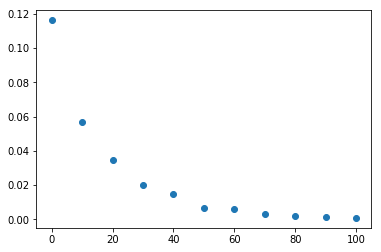

In [5]:
obs_t = np.linspace(0,100,11)
obs_A = first_order(obs_t, A0, k)
obs_A += obs_A*np.random.randn(obs_A.size)*0.1

plt.plot(obs_t, obs_A, 'o')

Scipy has a non-linear least squares fitting routine called `curve_fit`, which is defined in the `scipy.optimize` module. We will use this function to fit our simulated data in the typical manner. See the [docs for this method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to learn more about using this function.

In [6]:
fit, cov = spo.curve_fit(first_order, obs_t, obs_A, p0=(0.2, 0.1))

The fit parameters match pretty well with our "true" values. In addition, the returned covariance matrix can be used to calculate standard errors for the fit parameters.

In [7]:
sigma = np.sqrt(np.diag(cov))

print('Fit params:', fit)
print('Fit errors:', sigma)

Fit params: [ 0.11393287  0.05983613]
Fit errors: [ 0.00261215  0.00255086]


Plotting the data along with the fit shows that our fitting procedure has worked well. (In this case, our fit line would be much smoother if we increased the number of time points in the simulation.)

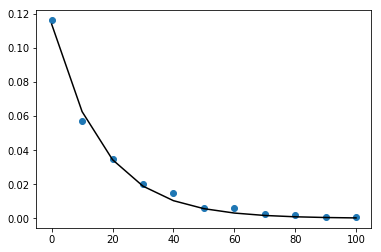

In [8]:
plt.plot(obs_t, obs_A, 'o')
plt.plot(obs_t, first_order(obs_t, *fit), 'k-')

It is important to always check the residuals as well to ensure that there are not any subtle issues with the fit.

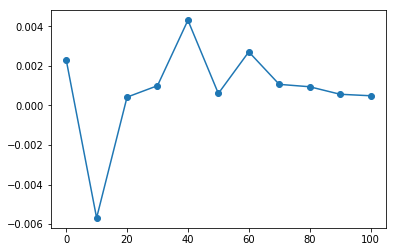

In [9]:
resid = obs_A - first_order(obs_t, *fit)
plt.plot(obs_t, resid, 'o-')

## Fitting using ODEnlls

Now we'd like to try the same fit but using the **ODEnlls** object class, which fits the data using ODE simulations. To start, we'll create our **ODEnlls** instance and load in our reactions, as we saw in the previous notebook.

In [10]:
x = ODEnlls()

In [11]:
rxn = 'A -> B'

f = io.StringIO('w+')
f.write(rxn)
f.seek(0)

x.read_rxns(f)

The **ODEnlls** instance can read in observed data from an external file. In this case, we'll create another `io.StringIO` object that contains our test data in the same manner as we did with our reaction data. Here's some requirements for the data file:

1. The first line must be a header line. Except for the first column, the column names for the concentration data must be equivalent to compound names that you used in your reaction file. (See above.)
2. The first column must be the times that the data were collected. The column name in this case doesn't matter.


In [12]:
f = io.StringIO('w+')

header = 'Times,A\n'
f.write(header)
print(header, end='')

for d in zip(obs_t, obs_A):
    line = '{:f},{:f}\n'.format(*d)
    print(line, end='')
    f.write(line)
f.seek(0)

Times,A
0.000000,0.116243
10.000000,0.056943
20.000000,0.034845
30.000000,0.019919
40.000000,0.014705
50.000000,0.006319
60.000000,0.005847
70.000000,0.002790
80.000000,0.001890
90.000000,0.001083
100.000000,0.000772


0

The `read_data` method reads the experimental data into our **ODEnlls** instance. This method is a *very* thin wrapper around the Pandas function `pandas.read_csv`. Any keyword arguments that you pass to this function will be sent directly to this Pandas function. See the [`read_csv` docs](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) for more info on this function.

*Note*: As with `read_rxns`, we could have passed in a file name as a string instead of using a file-like object. 

In [13]:
x.read_data(f)

In [14]:
x.data

,Times,A
0,0.0,0.116243
1,10.0,0.056943
2,20.0,0.034845
3,30.0,0.019919
4,40.0,0.014705
5,50.0,0.006319
6,60.0,0.005847
7,70.0,0.002790
8,80.0,0.001890
9,90.0,0.001083


The parameters must be set before attempting a fit. In this case, the inital concentration of *A* (`'A'`) and the rate constant (`'k1'`) are guesses that need to be optimized. However, the initial concentration of (`'B'`) must be fixed by using the `ptype` keyword argument.

In [15]:
x.set_param('A', 0.2)
x.set_param('k1', 0.1)
x.set_param('B', 0.0, ptype='fix')
x.params

,guess,fix
A,0.2,NaN
B,NaN,0.0
k1,0.1,NaN


Using the `plot` method that we've seen before, we can compare our data to our initial parameter guesses by passing in the `'guess'` argument string.

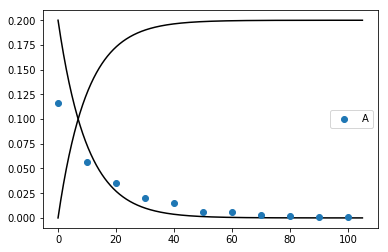

In [16]:
x.plot('guess')

Fitting the data is accomplished by using the `run_fit` method.

In [17]:
x.run_fit()

After fitting, the fit parameters and their standard errrors are added to the parameters table. As we can see, these parameters and errors are identical to the ones that we got from our analytical function. Here's the values from above for reference:
    
    Fit params: [ 0.11393287  0.05983613]
    Fit errors: [ 0.00261215  0.00255086]

In [18]:
x.params

,guess,fix,fit,error
A,0.2,NaN,0.113933,0.002612
B,NaN,0.0,0.000000,NaN
k1,0.1,NaN,0.059836,0.002551


The `plot` method can also be used to plot our fit relative to the data as well.

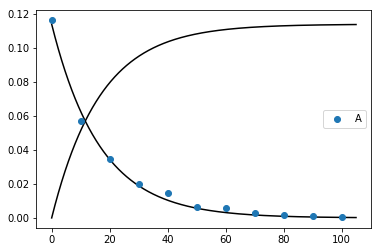

In [19]:
x.plot('fit')

The best-fit residual values are stored in an Pandas DataFrame attribute called `residuals`, and they can also be visualized with our `plot` method as well.

In [20]:
x.residuals

,Times,A
0,0.0,0.002310
1,10.0,-0.005687
2,20.0,0.000416
3,30.0,0.000993
4,40.0,0.004301
5,50.0,0.000600
6,60.0,0.002703
7,70.0,0.001062
8,80.0,0.000940
9,90.0,0.000561


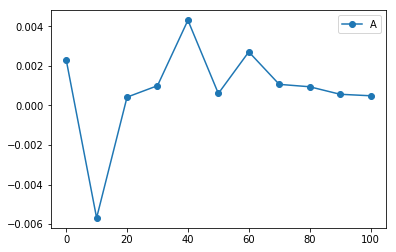

In [21]:
x.plot('res')

Several other statistical parameters from the fit are stored in a dictionary attribute called `stats`. These parameters are as follows:

* `'DOF'` : This is the degrees of freedom, which is essentially the number of data points less the number of fit parameters.
* `'R**2'` : The typical [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination). Be very careful using this parameter for highly non-linear fits such as these.
* `'chi**2'` : The [$\chi^2$ statistic](https://en.wikipedia.org/wiki/Chi-squared_test) for the fit.
* `'AIC'` : The [Akaike Information Criterion parameter](https://en.wikipedia.org/wiki/Akaike_information_criterion) for the fit. This is very useful for comparing different fits to your data that have different numbers of parameters.

In [22]:
x.stats

{'AIC': -100.12582906402727,
 'DOF': 9,
 'R**2': 0.99457689726940746,
 'chi**2': 6.7569889433302023e-05}